## The Second Generation Kalman Filter
##### To reduce sensitivity to the enormous variation in error in our dataset, the equation for uncertainty has changed. 


### Part 1) Isolating a lake, calculating error, water level mean as well as quartile means. 


In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load Appropriate Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import math, time
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
# Copy relevant data over (here, we'll be using the raw dataset).
!cp /content/drive/MyDrive/Kalman_Filter/combined_sentinel_raw.csv /content/ # Note! This is the raw dataset, not the 2 std dev dataset.

In [ ]:
# Step 0 is always loading and isolating the relevant data.
df = pd.read_csv("combined_sentinel_raw.csv")


In [ ]:
df = df.drop(columns=['Unnamed: 0'], axis=1)
df.head(2)

,date,lake,latitude,longitude,orbit,water_level
0,20160403,Athabasca,59.244637,-108.047469,303,208.303892
1,20160403,Athabasca,59.247528,-108.049405,303,208.131251


In [ ]:
# Isolate the readings from Lake Winnipeg
win = df[df['lake'] == 'Winnipeg']
win.head(2)

,date,lake,latitude,longitude,orbit,water_level
422462,20160401,Winnipeg,51.860057,-96.819518,283,217.4011
422463,20160401,Winnipeg,51.857120,-96.820913,283,217.5197


In [ ]:
# Step 1, Estimated Error and Estimated Uncertainty. 
# These will be needed for initialization of our Kalman Filter. 

# As each recording of water level on a lake shouldn't vary in the time it takes
#. for a single track, any recorded variance would be part of the error. 

win_error = [] # Create a list where each track's error can be collected. 
  
for i in win.date.unique(): # Collect the error of each track. 
  min = win[win['date'] == i].water_level.min()
  max = win[win['date'] == i].water_level.max() 
  error = max - min
  win_error.append(error)

avg_error = np.mean(win_error)
uncertainty = avg_error*avg_error # This is the old equation for uncertainty. Observe how enormous this number is. 
print("The basic error 'O' (in meters) is:", avg_error)
print("The estimated uncertainty ('O' * 'O') is:", uncertainty)

The basic error 'O' (in meters) is: 8.41012065934066
The estimated uncertainty ('O' * 'O') is: 70.73012950466857


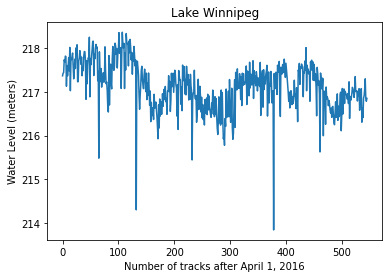

In [ ]:
# Step 2, uncovering the Process Uncertainty. 
# This is important for each training step after initialization. 

# Let us observe the patter of water levels. 

water_mean = [] # Create a repository for average water levels per track. 
for i in win.date.unique(): # Collect the mean of each track. 
  water = win[win['date'] == i].water_level.mean()
  water_mean.append(water)

x = range(len(win.date.unique()))
y = water_mean
plt.title("Lake Winnipeg")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Water Level (meters)")
plt.plot(x,y)
plt.show()

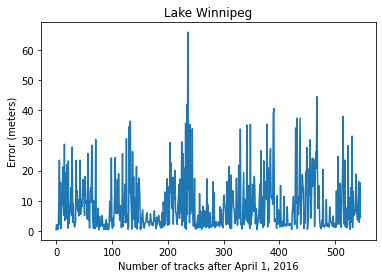

In [ ]:
# The water level plot has a one story to tell. 
# But does the error plot have a similar one?

x = range(546)
y = win_error
plt.title("Lake Winnipeg")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Error (meters)")
plt.plot(x,y)
plt.show()

In [ ]:
# Their stories are not the same and as of yet we do not know why. 
# Thus the Process Uncertainty is not low. 
# In addition, the European Space Agency stated that the error
# for the Sentinel III satellite is 10-15cm. 
# Simple EDA demonstrates this is not accurate. 
# We will use their number for Process Uncertainty. 
n = ((15+10)/2)/100
print("The Process noise 'Q', in meters, is:", n)

The Process noise 'Q', in meters, is: 0.125


In [ ]:
# Create a dataframe of the errors.
err = pd.DataFrame(win_error, columns = ['error'])
err.head()
# Transform features by scaling each feature to a given range, to help it become more accurate.
scaler = MinMaxScaler(feature_range=(-1, 1))
err['error'] = scaler.fit_transform(err['error'].values.reshape(-1,1))

In [ ]:
# Create an identically mapped list of water level averages. 
water_levels = []
for i in win.date.unique():
  avg = win[win['date'] == i].water_level.mean()
  water_levels.append(avg)

In [ ]:
change_water = [] # Create a list to store changes in water levels
for i in range(len(water_levels[1:])):
  change = water_levels[i] - water_levels[(i-1)]
  change_water.append(change)
add = np.mean(change_water) # To make this list as long as the previous two, I'll artificially add the mean of the list. 
change_water.insert(0, add)

In [ ]:
change_error = [] # Create a list to store changes in water levels
for i in range(len(win_error[1:])):
  change = win_error[i] - win_error[(i-1)]
  change_error.append(change)
add = np.mean(change_error) # To make this list as long as the previous two, I'll artificially add the mean of the list. 
change_error.insert(0, add)

In [ ]:
going_up = [] # Create a list to store a binary classification of inverse or not. 
nums = range(len(change_error))
for i in nums:
  if i >= 1: 
    if change_error[i-1] < change_error[i]:
      going_up.append(1) # Indicating that error is rising.
    else:
      going_up.append(0) # Indicating that error is not rising.
going_up.insert(0, 0) # To make this as long as the other lists, I'll artificially add a '0' to the first input. 

In [ ]:
# Create a dictionary of the lists. We will exclude 'errors' for now, until the data is normalized.
data = {"water_level": water_levels, "change_error": change_error, "change_water": change_water, "error_rising": going_up, "error": win_error}
win2 = pd.DataFrame(data=data)
win2.head()

,water_level,change_error,change_water,error_rising,error
0,217.365902,0.021177,-0.000122,0,0.348200
1,217.424961,-4.052768,0.515020,0,2.112597
2,217.441654,1.764397,0.059059,1,0.561211
3,217.732182,-1.551385,0.016692,0,0.495355
4,217.682788,-0.065857,0.290528,1,0.682247


In [ ]:
# We will one-hot-encode the error rising category. 
!pip install category_encoders
import category_encoders as ce
encoder = ce.OneHotEncoder(cols='error_rising')
encoded = encoder.fit_transform(win2)
encoded.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 530 kB/s 


,water_level,change_error,change_water,error_rising_1,error_rising_2,error
0,217.365902,0.021177,-0.000122,1,0,0.348200
1,217.424961,-4.052768,0.515020,1,0,2.112597
2,217.441654,1.764397,0.059059,0,1,0.561211
3,217.732182,-1.551385,0.016692,1,0,0.495355
4,217.682788,-0.065857,0.290528,0,1,0.682247


In [ ]:
# Normalize the columns, dropping the error column as we want a fully operational error prediction, for the Kalman Filter
from sklearn import preprocessing
encoded1 = encoded.drop(['error'], axis = 1)
xo = encoded1.values
min_max_scaler = preprocessing.MinMaxScaler()
xo_scaled = min_max_scaler.fit_transform(xo)
win3 = pd.DataFrame(xo_scaled, columns = encoded1.columns)
win3.head()

,water_level,change_error,change_water,error_rising_1,error_rising_2
0,0.779602,0.463550,0.489053,1.0,0.0
1,0.792690,0.427372,0.562756,1.0,0.0
2,0.796389,0.479030,0.497521,0.0,1.0
3,0.860770,0.449585,0.491459,1.0,0.0
4,0.849824,0.462777,0.530638,0.0,1.0


In [ ]:
# Adding the error column back in. 
win3['error'] = win_error
win3.head()

,water_level,change_error,change_water,error_rising_1,error_rising_2,error
0,0.779602,0.463550,0.489053,1.0,0.0,0.348200
1,0.792690,0.427372,0.562756,1.0,0.0,2.112597
2,0.796389,0.479030,0.497521,0.0,1.0,0.561211
3,0.860770,0.449585,0.491459,1.0,0.0,0.495355
4,0.849824,0.462777,0.530638,0.0,1.0,0.682247


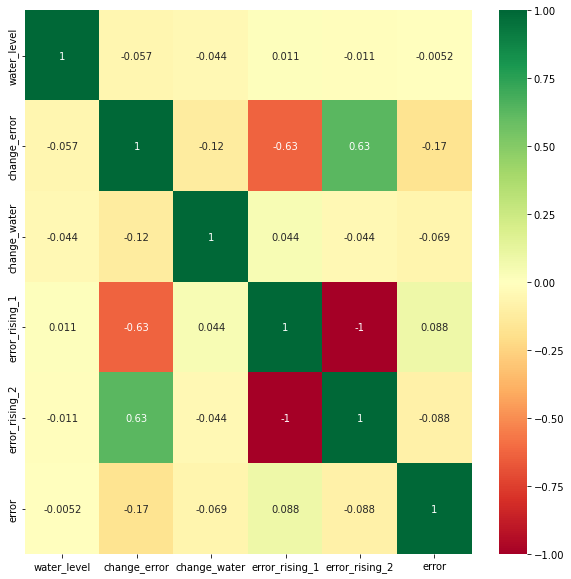

In [ ]:
# A final observation; a heatmap revealing correlation between predictor and target variables.
import seaborn as sns 
plt.figure(figsize=(10,10))
map = sns.heatmap(win3.corr(),annot=True,cmap="RdYlGn")

### Phase Two) Creating the Kalman Filter's Random Forest Regressor
##### Observing the unmodified initial Kalman Filter, somewhere between 75 and 100 timesteps it stopped trusting its own predictions and began almost mirroring the data. 
##### As we know from a human perspective, that the data is extremely (and randomly) noisy; a Kalman Filter that trusts the data isn't ideal. 
##### So we will use the Random Forest Regressor to predict the error of a given timestep, based on the data in the win3 dataframe of the previous timestep, every 39 steps (14*39=546). 

In [ ]:
# Import relevant libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


In [ ]:
# Now to create a modified target variable. 
# Error at timestep i, will be predicted by the data of win3 in timestep i-1. 
i = 39 # As example
predict = win3.iloc[(i-19):i-1]
target = win3.error.iloc[i-18:i]
#x_train, x_test, y_train, y_test = train_test_split(predict, target, test_size=0.2, random_state=42)

In [ ]:
# Instantiating a loading the random forest regressor model. 
clf = RandomForestRegressor(n_estimators=300)
clf.fit(predict, target)

RandomForestRegressor(n_estimators=300)

In [ ]:
# Testing the model's predictive capabilities. 
clf.score(predict,target)

0.8381623742824441

In [ ]:
# Not bad! 
# Now to see what the final prediction was, that would be inputed into the Kalman Filter as estimated error. 
predictions = clf.predict(predict)
print(predictions[17])

12.50258654433333


In [ ]:
# So 2.7917839499999975 would be the predicted error for the next timestep in the Kalman Filter. 

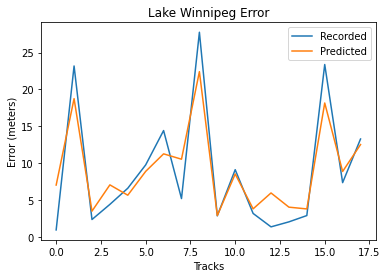

In [ ]:
x = range(len(target))
y1 = target
y2 = predictions
plt.title("Lake Winnipeg Error")
plt.xlabel("Tracks") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Error (meters)")
plt.plot(x,y1, label='Recorded')
plt.plot(x,y2, label='Predicted')
plt.legend()
plt.show()

### Phase 3) Building the modified Kalman Filter

##### Problem: How to create a Kalman Filter from the needed components: estimated measurements, estimated error, recorded measurements and error in the measurements (and process uncertainty)?

In [ ]:
# Step 3, the components of our Kalman Filter:
# Initialization
# Initial water level 
x_o = 217.3659023809524 

p_o = 5.149188784615385

# Initial Prediction
# (predicted water level at the next time step) x (1, 0) = x (0,0) --> Since our model has roughly constant dynamics between most readings.
x_n = 217.3659023809524 
# (Process Uncertainty) q = 0.125 --> Outlined above
q = 0.125
# (Predicted Error) p (1,0) = p (0,0) + q 
p_n = p_o + 0.125 
# Update values for future iterations
x_o = x_n
p_o = p_n 

# First Iteration
# Measure
# (water level measurement) z 1,0 = water_mean[1]
z = 217.42496111222854
# (error in the measurement) err 1,0 = win_error[1]^2
err = 4.2251933999999665

# Update
# (Kalman Gain) K1 = (P 1,0)/((P 1,0) + err)
k = p_n/(p_o + err) # --> 0.5552138741356417
# Estimating the current state: x 1,1 = x 1,0 + K1(z1 - x 1,0) 
x_n = x_o + k * (z-x_o) # --> 217.39912983978607
# Update the current estimate uncertainty: 
p_n = (1-k)*(p_o) 

# Prediction
# (predicted water level): 
x_n = x_o
# (extrapolated estimate uncertainty): 
p_n = p_o + q


In [ ]:
# Step 4, building the Model
#Initialization
_o = "old"
_n = "new"
x = "Water Level Estimations"
x_o = water_mean[0]
p = "Estimated Error" 
p_o = uncertainty

# Initial Prediction
x_n = x_o # (217.3659023809524) 
q = 0.125 # --> Process Uncertainty 
p_n = p_o + q 
x_o = x_n
p_o = p_n 


In [ ]:
kalman_gains = [] # --> To record the Kalman Gains per iteration.
water_est = [] # --> To record the predicted water levels. 
errors = [] # --> To record the estimated errors. 

for i in range(len(water_mean[1:])):
  # Measure
  z = water_mean[i]
  err = win_error[i] * win_error[i]
  # Update
  k = p_n /(p_o + err)
  kalman_gains.append(k)
  x_n = x_o + k * (z-x_o)
  water_est.append(x_n)
  p_n = (1-k)*(p_o)
  errors.append(p_n)
  x_o = x_n
  # Prediction
  x_n = x_o
  p_n = p_o + q
  p_o = p_n
  #Create the Random Forest Regressor pass
  if i > 20:
    if i%1==0:
      predict = win3.iloc[(i-20):(i-1)] # --> takes the data of win3 up until this timestep
      target = win3.error.iloc[i-19:i] # --> this timestep's error will be the target
      clf = RandomForestRegressor(n_estimators=300)
      clf.fit(predict, target)
      predictions = clf.predict(predict)
    # The most updated error, p_n, will become the prediction. 
      pred = predictions[18]
      answer = ((p_n*4)+pred)/5
      p_o = answer
  

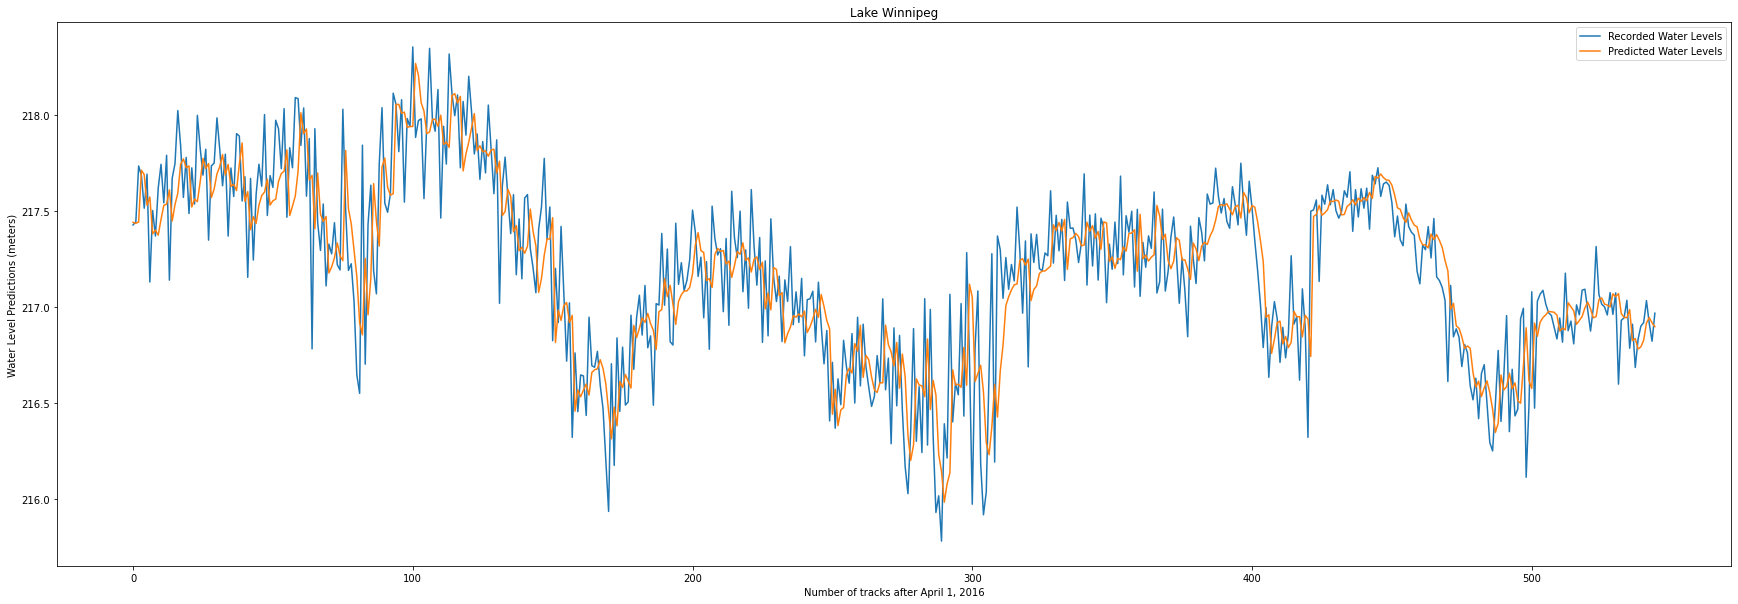

In [ ]:
# Now to plot the estimated water levels against the recorded measurements. 
x = range(len(water_mean[1:]))
y2 = water_est
y = water_mean[1:]

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Lake Winnipeg")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Water Level Predictions (meters)")
plt.plot(y, label = 'Recorded Water Levels')
plt.plot(y2, label = 'Predicted Water Levels')

plt.legend()
plt.show()

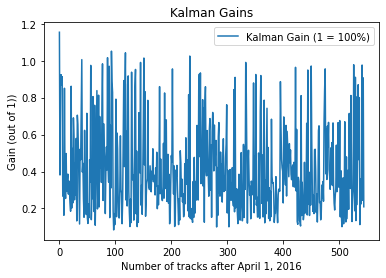

In [ ]:
# And finally to observe if the Kalman Gain was narrowing in on 0:
x = range(len(kalman_gains))
y = kalman_gains
plt.title("Kalman Gains")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Gain (out of 1))")
plt.plot(x,y, label = 'Kalman Gain (1 = 100%)')
plt.legend()
plt.show()

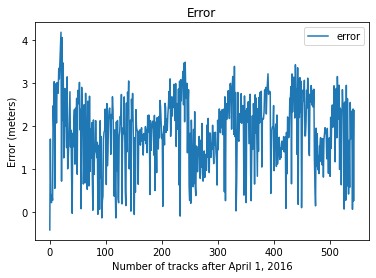

In [ ]:
# And finally to observe what the pattern of the errors is:
x = range(len(errors))
y = errors
plt.title("Error")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Error (meters)")
plt.plot(x,y, label='error')
plt.legend()
plt.show()

In [ ]:
# Success!

### The results are promising...
##### The large graph reveals that the RFR Kalman Filter trusted itself overall, significantly more than an unmofied KF (on the cleaned dataset). This is excellent performance for such noisy data. After the first 39 iterations, this trust jumped and seemed to steady at a higher level. 
##### The first small graph reveals that the Kalman Gains vacillated beteen high and low gain; an improvement relative to the unodified Kalman Filter, which steadily moved away from '0' instead of closing in on it. (The lack of trust in itself is directly related.)
##### The second small graph reveals that the error remained at a uniform level throughout the procession of the data, instead of steadily climbing in values. 
#### Possible avenues of future approach: 
##### Perhaps having a ML/DL model only kick in under certain environmental circumstances. For instances, in the unmodified Kalman Filter when the error hits a certain amount, or if the measurement uncertainty is too low (since, in this case we are aware it is not), or if the pattern of the errors/water levels changes drastically. 
##### The KalmanNet paper ran the DL model ever iteration of the Kalman Filter; perhaps that could be tried here. 
##### Instead of updating the predicted error only on the output of the RFR, perhaps taking the average of what the predicted error would have been, in combination with the RFR output. 
##### Using another machine learning (or deep learning) model
##### Using the model to predict the water level and the/ instead of the error. 
##### (More computationally expensive) Creating a dataframe column from the the past X predicted errors/water levels. 
##### (Less computationally expensive) Modifying the Kalman Filter itself, as there are many ways to modify it. 
#### Enjoy the compounding effects of experimenting! 

##### Here is one more approach, without ML, but with adjusting the process uncertainty (Q). 

In [ ]:
q = 0.250 # --> Process Uncertainty --> it was half this originally, at 0.125
kalman_gains = [] # --> To record the Kalman Gains per iteration.
water_est = [] # --> To record the predicted water levels. 
errors = [] # --> To record the estimated errors. 
for i in range(len(water_mean[1:])):
  # Measure:
  z = water_mean[i]
  err = win_error[i] * win_error[i]
  # Update
  k = p_n/(p_o + err)
  kalman_gains.append(k)
  x_n = x_o + k * (z-x_o)
  water_est.append(x_n) 
  p_n = (1-k)*(p_o)
  errors.append(p_n) 
  x_o = x_n 
  # Prediction
  x_n = x_o
  p_n = p_o + q
  p_o = p_n


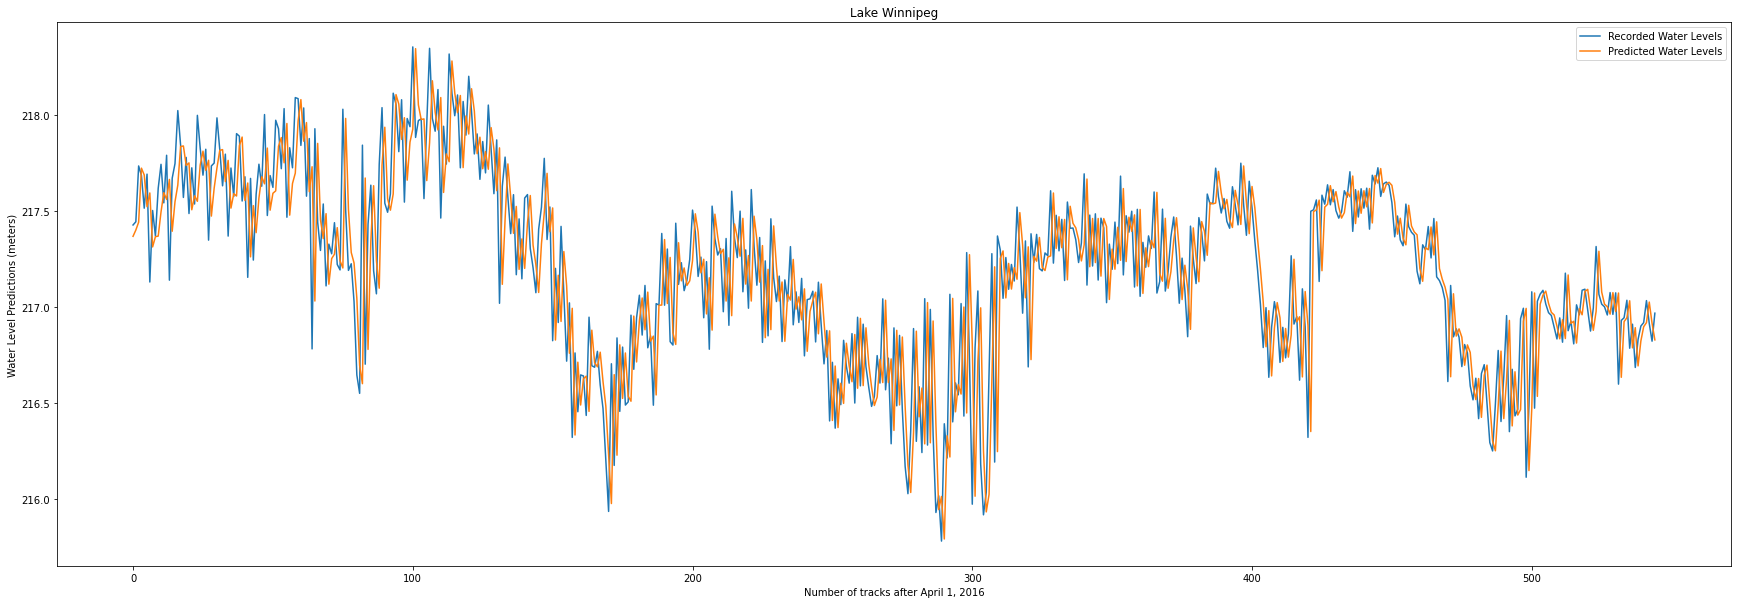

In [ ]:
# Now to plot the estimated water levels against the recorded measurements. 
x = range(len(water_mean[1:]))
y2 = water_est
y = water_mean[1:]

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Lake Winnipeg")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Water Level Predictions (meters)")
plt.plot(y, label = 'Recorded Water Levels')
plt.plot(y2, label = 'Predicted Water Levels')

plt.legend()
plt.show()

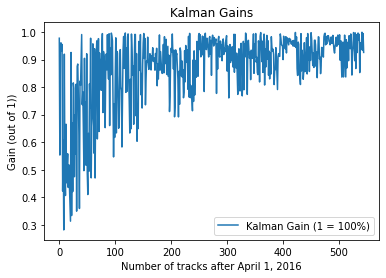

In [ ]:
# And finally to observe if the Kalman Gain was narrowing in on 0:
x = range(len(kalman_gains))
y = kalman_gains
plt.title("Kalman Gains")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Gain (out of 1))")
plt.plot(x,y, label = 'Kalman Gain (1 = 100%)')
plt.legend()
plt.show()

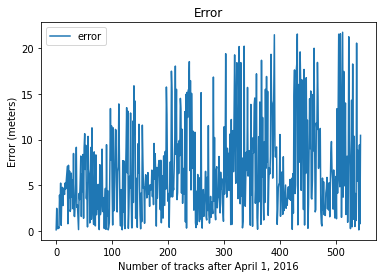

In [ ]:
# And finally to observe what the pattern of the errors is:
x = range(len(errors))
y = errors
plt.title("Error")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Error (meters)")
plt.plot(x,y, label='error')
plt.legend()
plt.show()

##### The results do vary, but not much, from the KF with Q=0.125
##### Now to use the RFR1_KF1 model with Q=0.250

In [ ]:
kalman_gains = [] # --> To record the Kalman Gains per iteration.
water_est = [] # --> To record the predicted water levels. 
errors = [] # --> To record the estimated errors. 
q = 0.250

for i in range(len(water_mean[1:])):
  # Measure
  z = water_mean[i]
  err = win_error[i] * win_error[i]
  # Update
  k = p_n /(p_o + err)
  kalman_gains.append(k)
  x_n = x_o + k * (z-x_o)
  water_est.append(x_n)
  p_n = (1-k)*(p_o)
  errors.append(p_n)
  x_o = x_n
  # Prediction
  x_n = x_o
  p_n = p_o + q
  p_o = p_n
  #Create the Random Forest Regressor pass
  if i > 1:
    if i%39==0:
      predict = win3.iloc[(i-38):i] # --> takes the data of win3 up until this timestep
      target = win3.error.iloc[i-37:i+1] # --> this timestep's error will be the target
      clf = RandomForestRegressor(n_estimators=300)
      clf.fit(predict, target)
      predictions = clf.predict(predict)
    # The most updated error, p_n, will become the prediction. 
      p_n = predictions[37]
      p_o = p_n - q

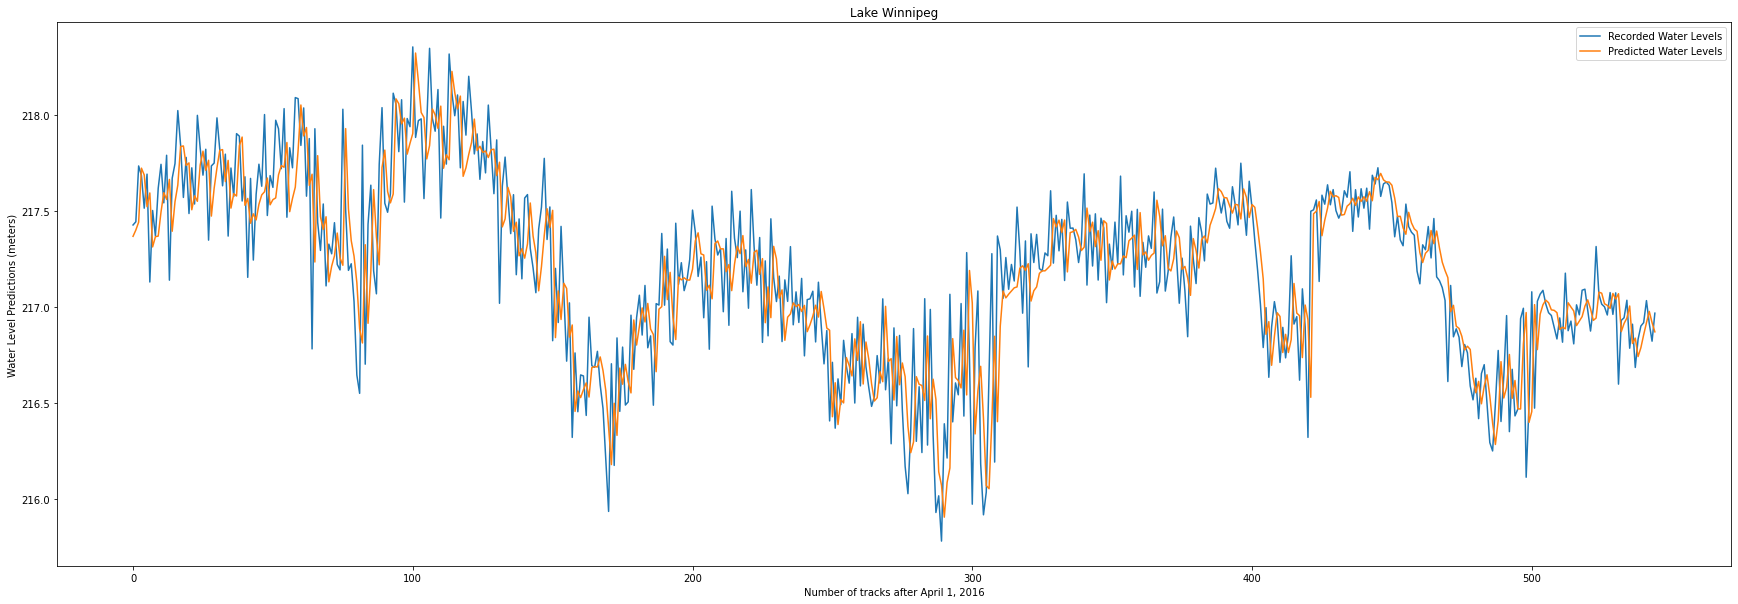

In [ ]:
# Now to plot the estimated water levels against the recorded measurements. 
x = range(len(water_mean[1:]))
y2 = water_est
y = water_mean[1:]

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Lake Winnipeg")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Water Level Predictions (meters)")
plt.plot(y, label = 'Recorded Water Levels')
plt.plot(y2, label = 'Predicted Water Levels')

plt.legend()
plt.show()

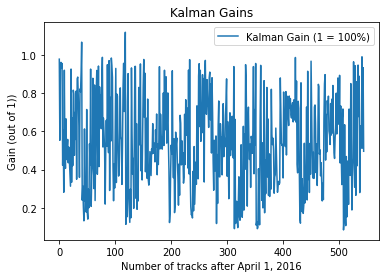

In [ ]:
# And finally to observe if the Kalman Gain was narrowing in on 0:
x = range(len(kalman_gains))
y = kalman_gains
plt.title("Kalman Gains")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Gain (out of 1))")
plt.plot(x,y, label = 'Kalman Gain (1 = 100%)')
plt.legend()
plt.show()

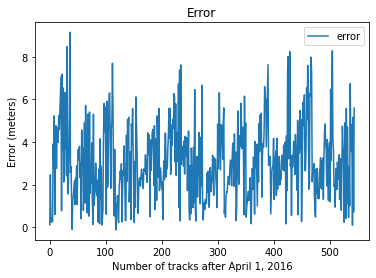

In [ ]:
# And finally to observe what the pattern of the errors is:
x = range(len(errors))
y = errors
plt.title("Error")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Error (meters)")
plt.plot(x,y, label='error')
plt.legend()
plt.show()

#### Results from experiment 1: 
##### So it seems that the RFR1_KF1 model likes a lower process uncertainty, as when it is higher both the gain and the errors are higher, and follow a unique pattern of low then high variability. 